In [1]:
import numpy as np
import pandas as pd
import math
import os
import sys
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap

sys.path.append("../..")

from MagneticFluxRopeModels.ECModel import ECModel

## Phase 1: Simulation

We make a sweep of simulations and fittings, and store the results in a csv file.

In [2]:
from collections import namedtuple

ParameterRange = namedtuple("ParameterRange", ["start", "end", "number"])

In [ ]:
def sweep_ec_model_fitting(delta_range: ParameterRange, y_0_range: ParameterRange, tau_range: ParameterRange, B_z_0_range: ParameterRange, noise_level: float = 0.05, noise_type: str = "gaussian", save_folder: str | None = None):
    """Make a sweep of delta and impact parameter (y_0), in which for each pair of parameters, an ECModel magnetic flux rope crossing is simulated,
    together with some gaussian noise. The simulated data is then fitted with another ECModel, and the fitted delta and y_0 parameters are recovered.

    Args:
        noise_level (float): noise level used, as a fraction of B_z_0.
        noise_type (str, optional): type of noise. Defaults to "gaussian".
        n_delta (int, optional): number of samples to split the delta range. Defaults to 10.
        n_y_0 (int, optional): number of samples to split the impact parameter range. Defaults to 10.
        save_folder (str | None, optional): folder where to save the results. Defaults to None.

    Returns:
        _type_: a pandas dataframe with four columns: delta, y_0, delta_opt, y_0_opt.
    """
    print(f"Noise level = {noise_level:.4f}.")

    results = {"delta": [],
               "y_0": [],
               "tau": [],
               "B_z_0": [],
               "psi": [],
               "delta_opt": [],
               "y_0_opt": [],
               "tau_opt": [],
               "B_z_0_opt": [],
               "psi_opt": [],
               "f_opt": []}
    
    psi = math.radians(30.0)

    for delta in np.linspace(delta_range.start, delta_range.end, delta_range.number, endpoint=True):
        for y_0 in np.linspace(y_0_range.start, y_0_range.end, y_0_range.number, endpoint=True):
            for tau in np.linspace(tau_range.start, tau_range.end, tau_range.number, endpoint=True):
                for B_z_0 in np.linspace(B_z_0_range.start, B_z_0_range.end, B_z_0_range.number, endpoint=True):
                    # Create the EC model.
                    my_ec_model = ECModel(delta=delta, psi=psi, tau=tau, B_z_0=B_z_0)

                    # Simulate the crossing.
                    df = my_ec_model.simulate_crossing(v_sc=450.0, y_0=y_0, noise_type=noise_type, epsilon=noise_level*my_ec_model.B_z_0)
                    
                    if df is None:
                        print(f"Incompatible parameters: delta = {delta}, y_0 = {y_0}, psi = {math.degrees(psi):.2f} deg.")
                        continue

                    model_params = {
                        "delta": {"mode": "optimised", "initial_value": 0.8, "bounds": [0.5, 1]},
                        #"psi": {"mode": "fixed", "value": psi},
                        "psi": {"mode": "optimised", "initial_value": math.radians(45), "bounds": [0.01, math.radians(180)*0.99]},
                        "tau": {"mode": "optimised", "initial_value": 1.4, "bounds": [0.1, 2.0]},
                        "B_z_0": {"mode": "optimised", "initial_value": 8.0, "bounds": [1, 20]}
                        }
                    
                    crossing_params = {
                        "y_0": {"mode": "optimised", "initial_value": 0.0, "bounds": [-0.95, 0.95]},
                        "v_sc": {"mode": "fixed", "value": 450.0}
                        }
                    
                    result = ECModel.fit(ECModel, df, model_params, crossing_params, residue_method="MSE")

                    if result is not None:
                        fitted_model, crossing_params_opt, _, optimisation_result = result
                        delta_opt = fitted_model.delta
                        y_0_opt = crossing_params_opt["y_0"]
                        tau_opt = fitted_model.tau
                        B_z_0_opt = fitted_model.B_z_0
                        psi_opt = fitted_model.psi
                        f_opt = optimisation_result["f_opt"]
                        print(f"Delta = {delta:.3f}, y_0 = {y_0:.3f}, tau = {tau:.3f}, B_z_0 = {B_z_0:.3f}, psi = {psi:.3f} --> Opt. delta = {delta_opt:.3f}, Opt. y_0 = {y_0_opt:.3f}, Opt. tau = {tau_opt:.3f}, B_z_0 = {B_z_0:.3f}, psi = {psi_opt:.3f} --> f_opt = {f_opt:.3f}")
                    else:
                        delta_opt = 1e9
                        y_0_opt = 1e9
                        tau_opt = 1e9
                        B_z_0_opt = 1e9
                        psi_opt = 1e9

                    results["delta"].append(delta)
                    results["y_0"].append(y_0)
                    results["tau"].append(tau)
                    results["B_z_0"].append(B_z_0)
                    results["psi"].append(psi)
                    results["delta_opt"].append(delta_opt)
                    results["y_0_opt"].append(y_0_opt)
                    results["tau_opt"].append(tau_opt)
                    results["B_z_0_opt"].append(B_z_0_opt)
                    results["psi_opt"].append(psi_opt)
                    results["f_opt"].append(f_opt)
            
    df = pd.DataFrame(results)
    if save_folder is not None:
        df.to_csv(f"{save_folder}/sim_results_{noise_level:.4f}.csv", index=False)

    return df

# Study 1: Varying noise level

In [90]:
save_folder: str = "data4"

if not os.path.isdir(save_folder):
    os.makedirs(save_folder)

noise_levels: list[float] = [0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12]

df = None

for noise_level in noise_levels:
    df_buff = sweep_ec_model_fitting(noise_level=noise_level,
                                    delta_range=ParameterRange(0.95, 0.95, 1),
                                    y_0_range=ParameterRange(0.1, 0.1, 1),
                                    tau_range=ParameterRange(1.3, 1.3, 1),
                                    B_z_0_range=ParameterRange(10, 10, 1))
    
    if df is None:
        df = df_buff
    else:
        df = pd.concat([df, df_buff], ignore_index=True)

# Add the noise levels in a separate column.
df["noise_level"] = noise_levels

# Save the dataframe.
df.to_csv("data4/all_noises_delta_95.csv", index=False)

Noise level = 0.0010.
0.5235987755982988
Delta = 0.950, y_0 = 0.100, tau = 1.300, B_z_0 = 10.000, psi = 0.524 --> Opt. delta = 0.951, Opt. y_0 = 0.100, Opt. tau = 1.299, B_z_0 = 10.000, psi = 0.508 --> f_opt = 0.000
Noise level = 0.0050.
0.5235987755982988
Delta = 0.950, y_0 = 0.100, tau = 1.300, B_z_0 = 10.000, psi = 0.524 --> Opt. delta = 0.953, Opt. y_0 = 0.100, Opt. tau = 1.297, B_z_0 = 10.000, psi = 0.446 --> f_opt = 0.006
Noise level = 0.0100.
0.5235987755982988
Delta = 0.950, y_0 = 0.100, tau = 1.300, B_z_0 = 10.000, psi = 0.524 --> Opt. delta = 0.957, Opt. y_0 = 0.100, Opt. tau = 1.294, B_z_0 = 10.000, psi = 0.369 --> f_opt = 0.026
Noise level = 0.0200.
0.5235987755982988
Delta = 0.950, y_0 = 0.100, tau = 1.300, B_z_0 = 10.000, psi = 0.524 --> Opt. delta = 0.963, Opt. y_0 = 0.099, Opt. tau = 1.287, B_z_0 = 10.000, psi = 0.208 --> f_opt = 0.102
Noise level = 0.0300.
0.5235987755982988
Delta = 0.950, y_0 = 0.100, tau = 1.300, B_z_0 = 10.000, psi = 0.524 --> Opt. delta = 0.970, Op

In [91]:
df = pd.read_csv("data4/all_noises_delta_95.csv")
df =  process_results(df)
magnitudes = ["delta", "y_0", "tau", "B_z_0", "psi"]

df_low_noise = df.loc[df["noise_level"] <= 0.05, :]

polynomials = dict()
for mag in magnitudes:
    polynomials[mag] = np.polyfit(x=df_low_noise["noise_level"], y=df_low_noise[f"{mag}_opt"], deg=2)

polynomials

{'delta': array([12.15770377,  0.45930141,  0.95016855]),
 'y_0': array([ 0.28918135, -0.0717058 ,  0.10009762]),
 'tau': array([-9.15459189, -0.49159977,  1.29995343]),
 'B_z_0': array([27.36735988,  1.19290409, 10.0004322 ]),
 'psi': array([ 4.21851765e+04, -1.92697421e+03,  3.29164811e+01])}

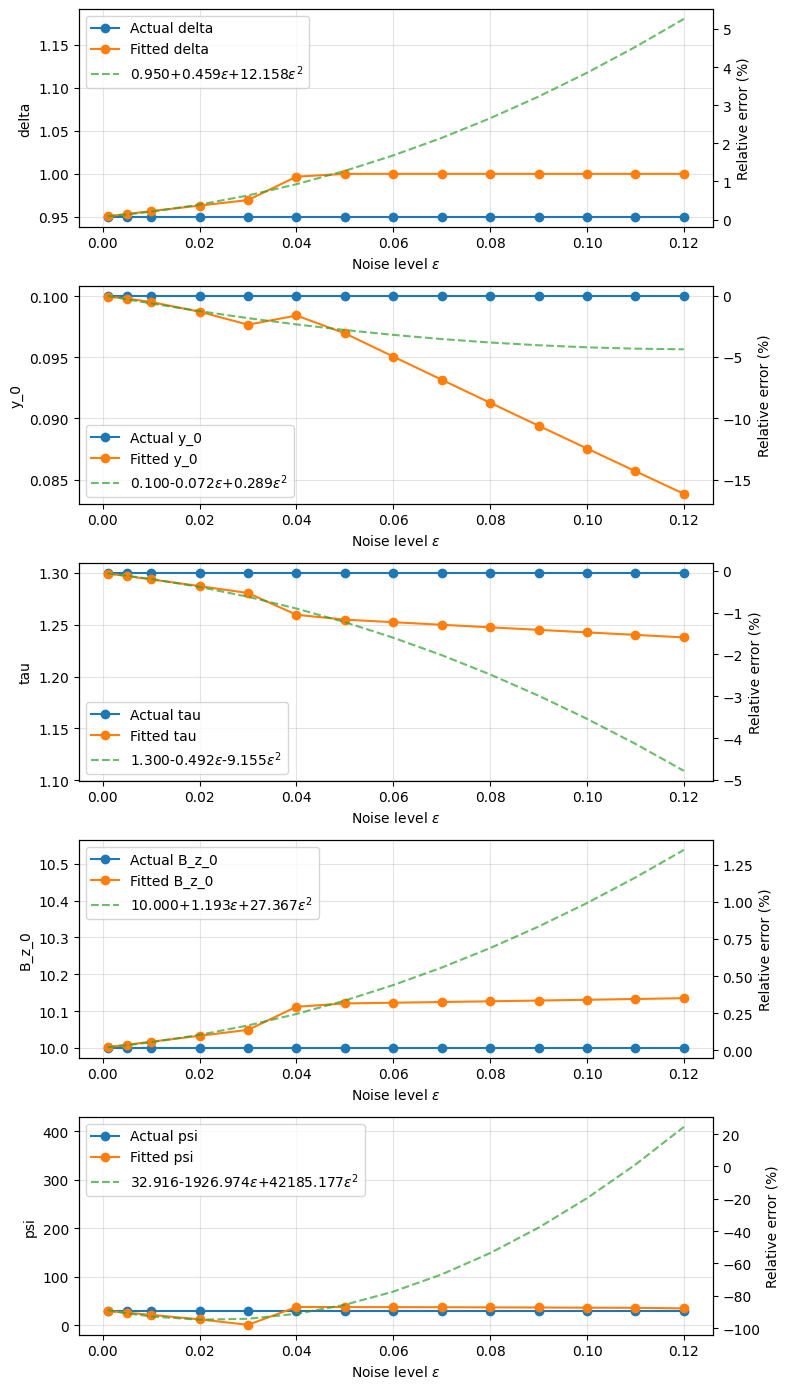

In [92]:
fig, ax = plt.subplots(len(magnitudes), 1, figsize=(8, 14), tight_layout=True)

for idx, mag in enumerate(magnitudes):
    # Left column.
    ax[idx].plot(df["noise_level"], df[mag], "-o", label=f"Actual {mag}")
    ax[idx].plot(df["noise_level"], df[f"{mag}_opt"], "-o", label=f"Fitted {mag}")

    poly = polynomials[mag]
    polynomial_fit = np.polyval(poly, df["noise_level"])

    poly_label = f"{poly[2]:.3f}"
    if poly[1] >= 0:
        poly_label += "+"
    poly_label += f"{poly[1]:.3f}$\\epsilon$"
    if poly[0] >= 0:
        poly_label += "+"
    poly_label += f"{poly[0]:.3f}$\\epsilon^2$"

    ax[idx].plot(df["noise_level"], polynomial_fit, "--", alpha=0.7, label=poly_label)

    ax[idx].set_xlabel(r"Noise level $\epsilon$")
    ax[idx].set_ylabel(mag)
    ax[idx].grid(alpha=0.35)
    ax[idx].legend()


    ax2 = ax[idx].twinx()
    ax2.plot(df["noise_level"], df[f"{mag}_rel_error"]*100, alpha=0)
    ax2.set_ylabel("Relative error (%)")

plt.show()

In [ ]:
save_folder: str = "data3"

if not os.path.isdir(save_folder):
    os.makedirs(save_folder)

noise_levels: list[float] = [0.005] #, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10]

for noise_level in noise_levels:
    df = sweep_ec_model_fitting(noise_level=noise_level,
                                    delta_range=ParameterRange(0.6, 0.95, 5),
                                    y_0_range=ParameterRange(0, 0.7, 5),
                                    tau_range=ParameterRange(0.5, 1.5, 4),
                                    B_z_0_range=ParameterRange(5, 15, 3),
                                    save_folder=save_folder)

Noise level = 0.0050.
0.5235987755982988
Delta = 0.600, y_0 = 0.000, tau = 0.500, B_z_0 = 5.000, psi = 0.524 --> Opt. delta = 0.543, Opt. y_0 = -0.000, Opt. tau = 0.553, B_z_0 = 5.000, psi = 1.321 --> f_opt = 0.002
0.5235987755982988
Delta = 0.600, y_0 = 0.000, tau = 0.500, B_z_0 = 10.000, psi = 0.524 --> Opt. delta = 0.601, Opt. y_0 = -0.000, Opt. tau = 0.501, B_z_0 = 10.000, psi = 0.521 --> f_opt = 0.006
0.5235987755982988
Delta = 0.600, y_0 = 0.000, tau = 0.500, B_z_0 = 15.000, psi = 0.524 --> Opt. delta = 0.543, Opt. y_0 = -0.000, Opt. tau = 0.553, B_z_0 = 15.000, psi = 1.321 --> f_opt = 0.014
0.5235987755982988
Delta = 0.600, y_0 = 0.000, tau = 0.833, B_z_0 = 5.000, psi = 0.524 --> Opt. delta = 0.601, Opt. y_0 = -0.000, Opt. tau = 0.834, B_z_0 = 5.000, psi = 0.520 --> f_opt = 0.002
0.5235987755982988
Delta = 0.600, y_0 = 0.000, tau = 0.833, B_z_0 = 10.000, psi = 0.524 --> Opt. delta = 0.601, Opt. y_0 = -0.000, Opt. tau = 0.834, B_z_0 = 10.000, psi = 0.520 --> f_opt = 0.006
0.52359

In [63]:
df = pd.read_csv("data3/sim_results_0.0050.csv")

def process_results(df: pd.DataFrame) -> pd.DataFrame:
    df["psi"] = np.rad2deg(df["psi"])
    df["psi_opt"] = np.rad2deg(df["psi_opt"])

    df["delta_error"] = df["delta_opt"] - df["delta"]
    df["y_0_error"] = df["y_0_opt"] - df["y_0"]
    df["tau_error"] = df["tau_opt"] - df["tau"]
    df["B_z_0_error"] = df["B_z_0_opt"] - df["B_z_0"]
    df["psi_error"] = df["psi_opt"] - df["psi"]

    df["delta_rel_error"] = df["delta_error"] / df["delta"]
    df["y_0_rel_error"] = df["y_0_error"] / df["y_0"]
    df["tau_rel_error"] = df["tau_error"] / df["tau"]
    df["B_z_0_rel_error"] = df["B_z_0_error"] / df["B_z_0"]
    df["psi_rel_error"] = df["psi_error"] / df["psi"]
    return df

df = process_results(df)
df.head()

,delta,y_0,tau,B_z_0,psi,delta_opt,y_0_opt,tau_opt,B_z_0_opt,psi_opt,...,delta_error,y_0_error,tau_error,B_z_0_error,psi_error,delta_rel_error,y_0_rel_error,tau_rel_error,B_z_0_rel_error,psi_rel_error
0,0.6,0.0,0.500000,5.0,30.0,0.543153,-0.000085,0.552893,5.004276,75.714461,...,-0.056847,-0.000085,0.052893,0.004276,45.714461,-0.094745,-inf,0.105786,0.000855,1.523815
1,0.6,0.0,0.500000,10.0,30.0,0.600858,-0.000108,0.500562,10.008571,29.871839,...,0.000858,-0.000108,0.000562,0.008571,-0.128161,0.001429,-inf,0.001125,0.000857,-0.004272
2,0.6,0.0,0.500000,15.0,30.0,0.543153,-0.000085,0.552893,15.012828,75.714451,...,-0.056847,-0.000085,0.052893,0.012828,45.714451,-0.094745,-inf,0.105786,0.000855,1.523815
3,0.6,0.0,0.833333,5.0,30.0,0.601432,-0.000180,0.834417,5.004292,29.786621,...,0.001432,-0.000180,0.001083,0.004292,-0.213379,0.002387,-inf,0.001300,0.000858,-0.007113
4,0.6,0.0,0.833333,10.0,30.0,0.601433,-0.000180,0.834416,10.008587,29.786711,...,0.001433,-0.000180,0.001083,0.008587,-0.213289,0.002388,-inf,0.001300,0.000859,-0.007110


In [5]:
df[df["f_opt"] > 0.5]

,delta,y_0,tau,B_z_0,psi,delta_opt,y_0_opt,tau_opt,B_z_0_opt,psi_opt,f_opt,delta_error,y_0_error,tau_error,B_z_0_error,psi_error,delta_rel_error,y_0_rel_error,tau_rel_error,B_z_0_rel_error
101,0.6875,0.525,0.833333,15.0,30.0,0.530619,0.345120,0.508864,10.599223,31.612783,8.536551,-0.156881,-0.179880,-0.324469,-4.400777,1.612783,-0.228191,-0.342629,-0.389363,-0.293385
236,0.8625,0.700,1.166667,15.0,30.0,0.519913,0.400743,0.506631,9.004433,27.060541,14.143357,-0.342587,-0.299257,-0.660036,-5.995567,-2.939459,-0.397202,-0.427510,-0.565745,-0.399704


In [6]:
df_filt = df[df["f_opt"] <= 0.5]

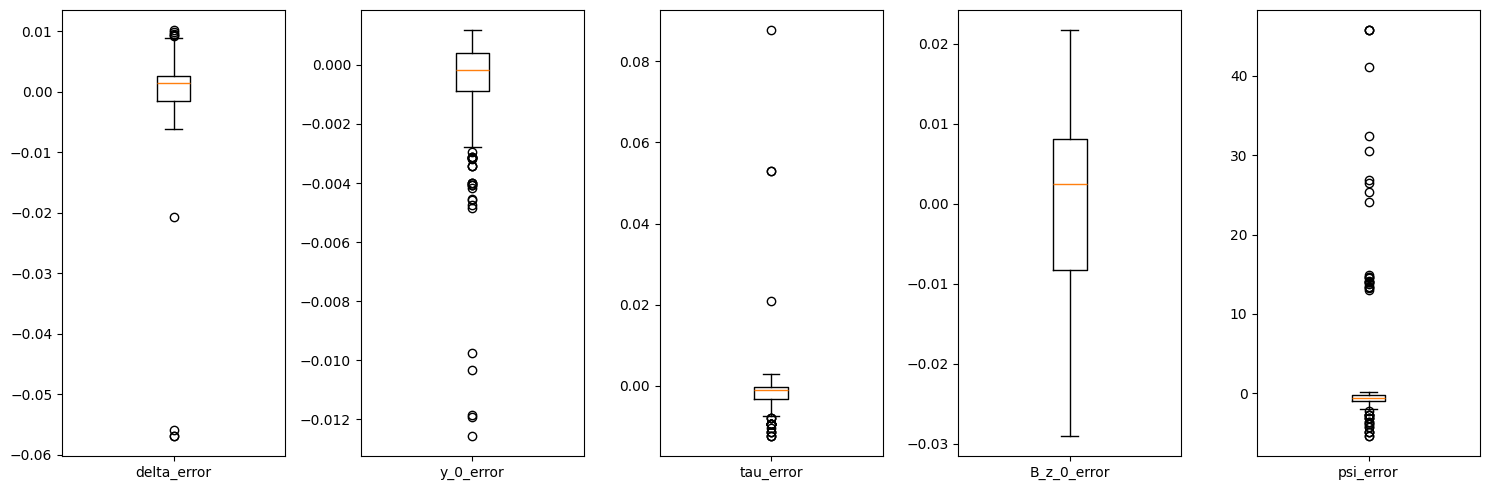

In [85]:
all_parameters = ["delta", "y_0", "tau", "B_z_0", "psi"]

fig, ax = plt.subplots(1,len(all_parameters), figsize=(15, 5), tight_layout=True)
for idx, param in enumerate(all_parameters):
    error_name = f"{param}_error"
    ax[idx].boxplot(df_filt[error_name])
    ax[idx].set_xticks([1])
    ax[idx].set_xticklabels([error_name])
plt.show()

In [43]:
df_delta_agg = df_filt.groupby("delta").std()
df_delta_agg

,y_0,tau,B_z_0,psi,delta_opt,y_0_opt,tau_opt,B_z_0_opt,psi_opt,f_opt,delta_error,y_0_error,tau_error,B_z_0_error,psi_error,delta_rel_error,y_0_rel_error,tau_rel_error,B_z_0_rel_error
delta,,,,,,,,,,,,,,,,,,,
0.6000,0.249576,0.375823,4.116935,0.0,0.012447,0.248418,0.371317,4.114225,10.084583,0.005440,0.012447,0.001477,0.015793,0.011039,10.084583,0.020744,NaN,0.024015,0.000991
0.6875,0.250649,0.378406,4.099151,0.0,0.003766,0.249773,0.376347,4.097470,5.396675,0.005386,0.003766,0.001268,0.004595,0.011626,5.396675,0.005478,NaN,0.006278,0.001079
0.7750,0.249576,0.375823,4.116935,0.0,0.002771,0.249209,0.374538,4.115667,0.237883,0.005416,0.002771,0.000795,0.002505,0.012115,0.237883,0.003576,NaN,0.001930,0.001115
0.8625,0.247415,0.378406,4.099151,0.0,0.002035,0.247603,0.377462,4.100022,0.426630,0.005353,0.002035,0.000493,0.001239,0.009360,0.426630,0.002359,NaN,0.000890,0.000889
0.9500,0.249576,0.375823,4.116935,0.0,0.002732,0.248180,0.374648,4.117223,10.456542,0.005370,0.002732,0.003370,0.002385,0.004642,10.456542,0.002876,NaN,0.001992,0.000708


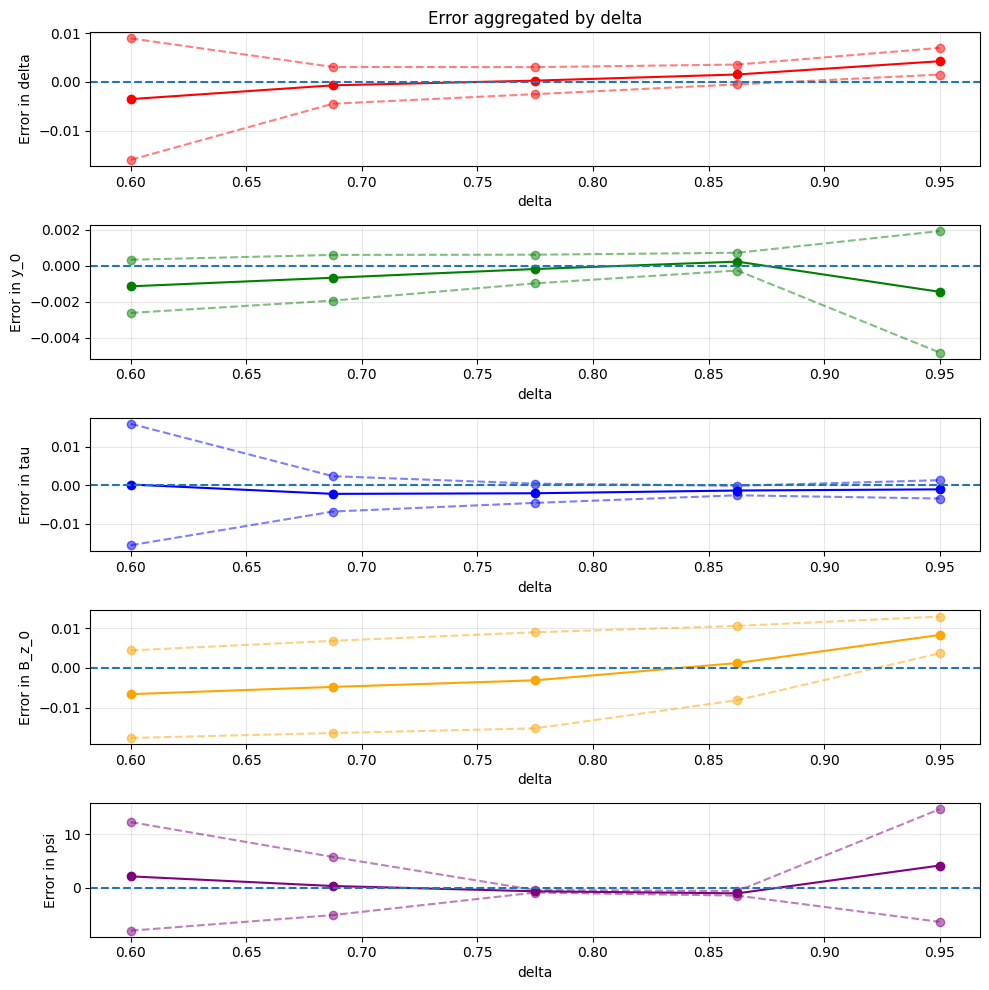

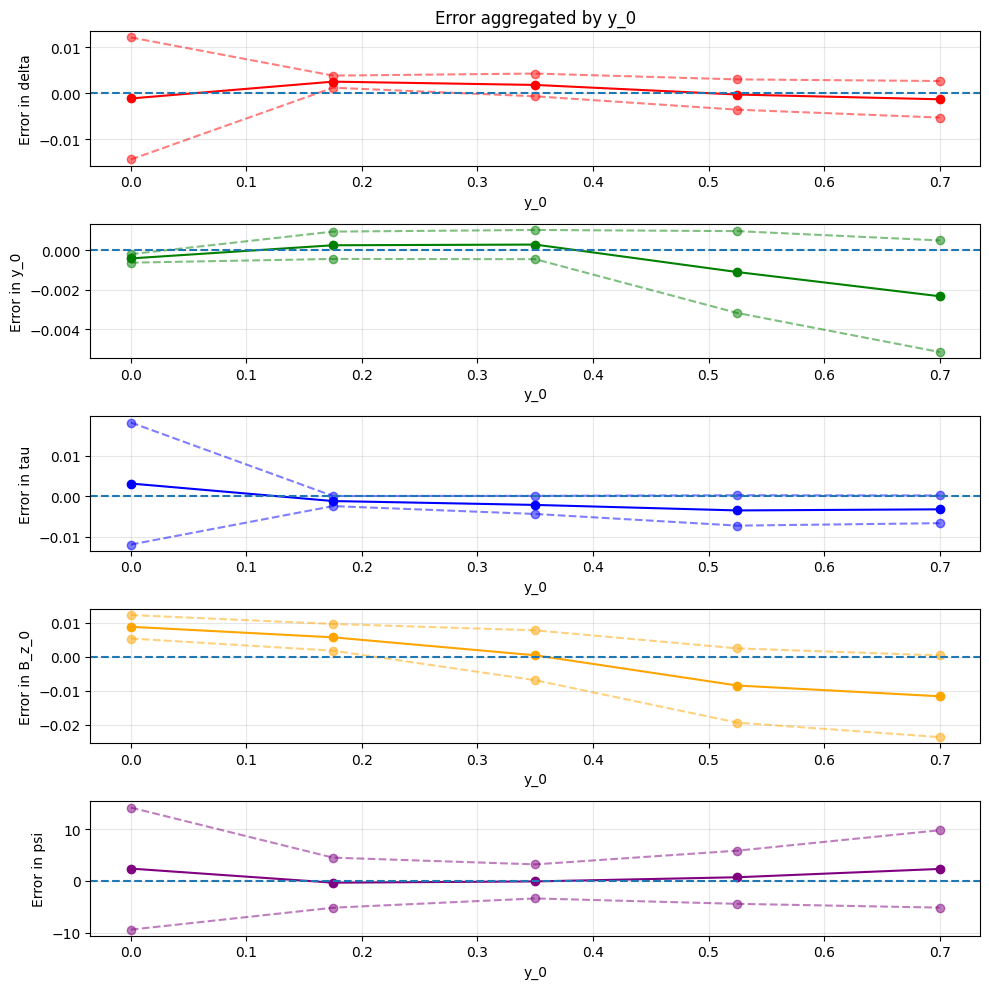

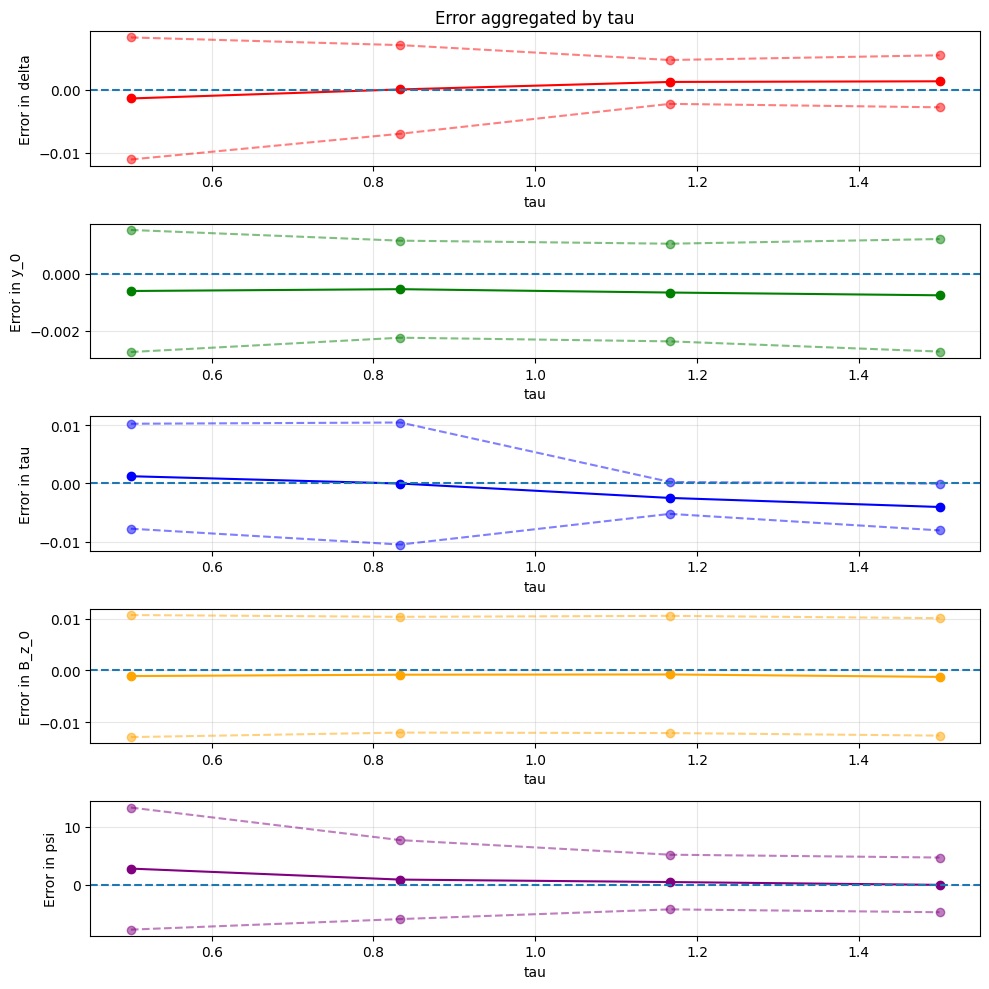

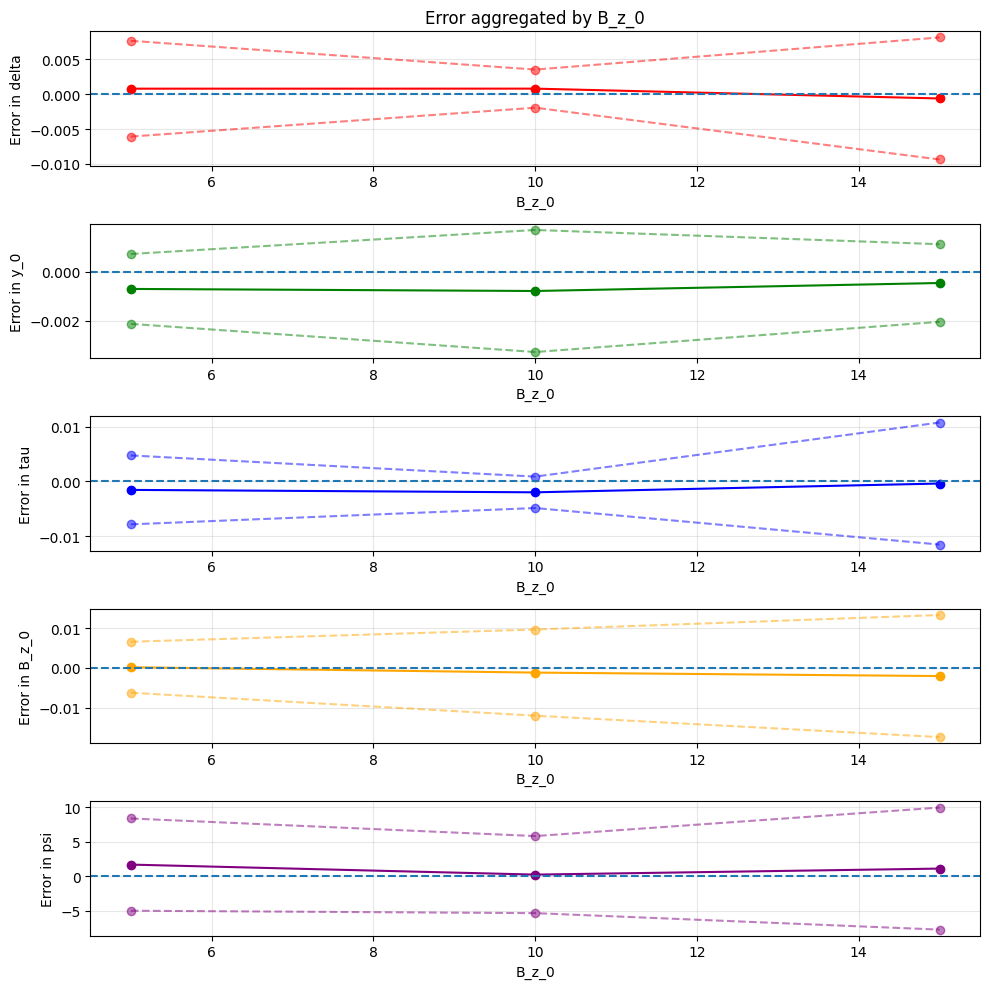

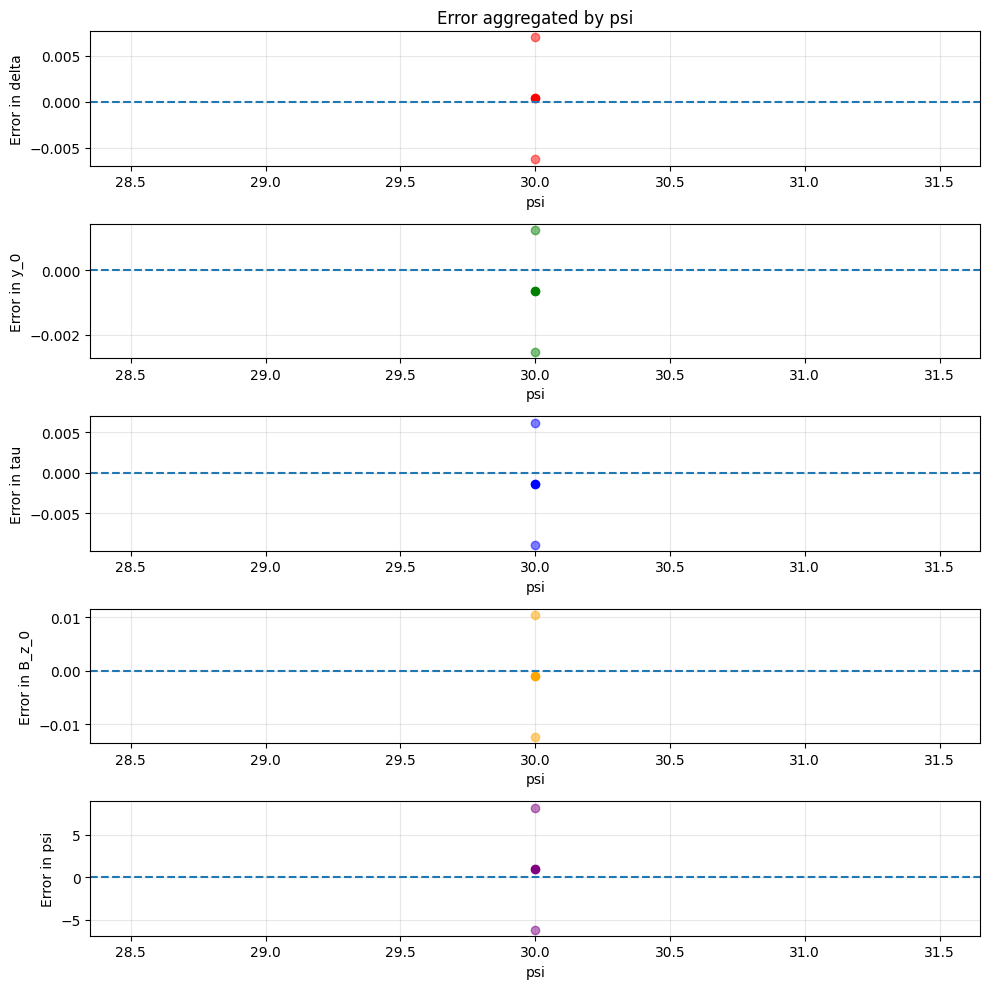

In [84]:
def plot_error_aggregates() -> None:
    all_parameters = ["delta", "y_0", "tau", "B_z_0", "psi"]
    colors = dict(zip(all_parameters, ["r", "g", "b", "orange", "purple"]))

    for parameter in all_parameters:
        df_agg = df_filt.groupby(parameter)
        df_agg_mean = df_agg.mean()
        df_agg_std = df_agg.std()
        
        fig, ax = plt.subplots(len(all_parameters), 1, tight_layout=True, figsize=(10, 10))


        for idx, a_param in enumerate(all_parameters):
            mean_error = df_agg_mean[f"{a_param}_error"]
            std_error = df_agg_std[f"{a_param}_error"]
            ax[idx].plot(df_agg_mean.index, mean_error, "-o", label=a_param, c=colors[a_param])
            ax[idx].plot(df_agg_mean.index, mean_error + std_error, "--o", c=colors[a_param], alpha=0.5)
            ax[idx].plot(df_agg_mean.index, mean_error - std_error, "--o", c=colors[a_param], alpha=0.5)
            ax[idx].axhline(0, linestyle="--")
            ax[idx].set_xlabel(parameter)
            ax[idx].set_ylabel(f"Error in {a_param}")
            ax[idx].grid(alpha=0.3)
        
        ax[0].set_title(f"Error aggregated by {parameter}")
        plt.show()

plot_error_aggregates()

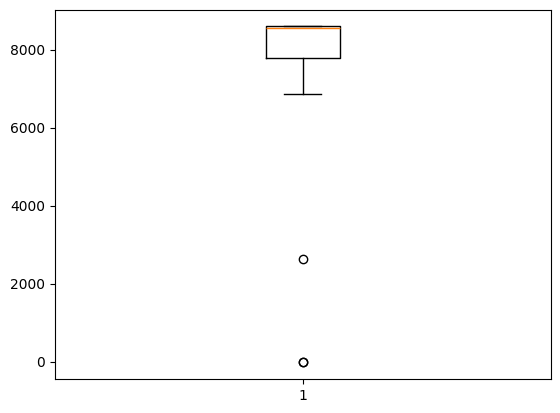

In [ ]:
plt.boxplot(np.rad2deg(df["psi_error"]))
plt.show()

<>:6: SyntaxWarning: invalid escape sequence '\d'
<>:6: SyntaxWarning: invalid escape sequence '\d'
/var/folders/q2/zrh3sz712dbc665prw9v99q80000gn/T/ipykernel_6222/2719748985.py:6: SyntaxWarning: invalid escape sequence '\d'
  labels = ["$\delta$", r"$\tau$", "$B_0^z$"]


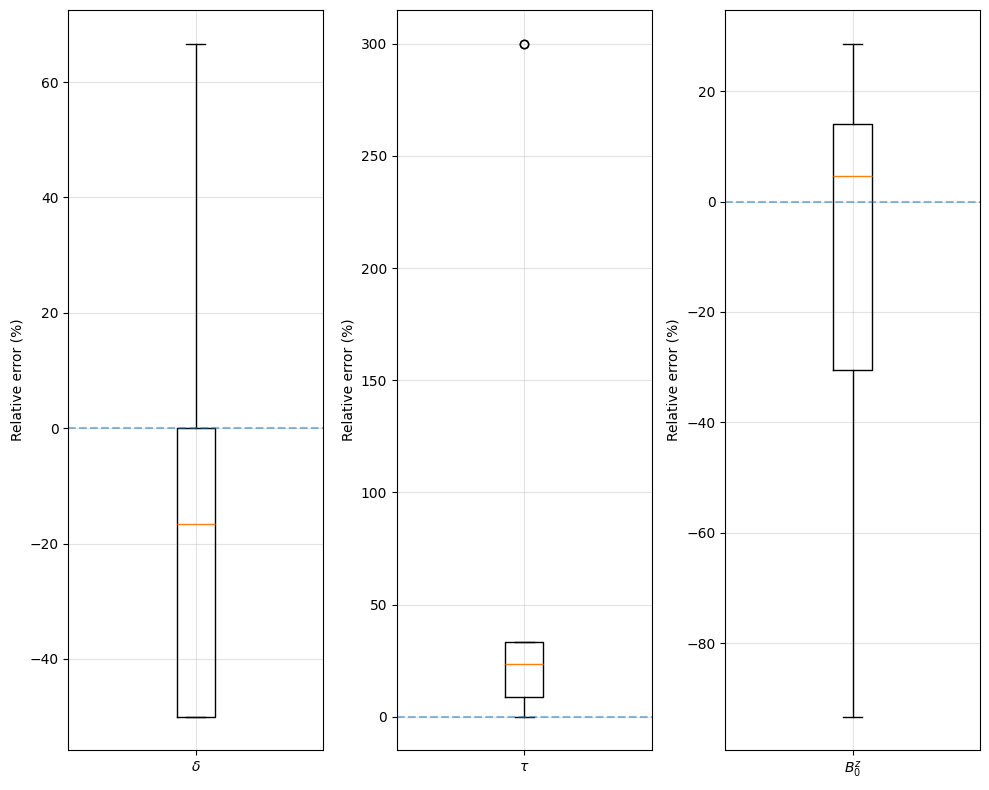

In [ ]:
fig, ax = plt.subplots(1, 3, tight_layout=True, figsize=(10, 8))
ax[0].boxplot(df["delta_rel_error"]*100)
ax[1].boxplot(df["tau_rel_error"]*100)
ax[2].boxplot(df["B_z_0_rel_error"]*100)

labels = ["$\delta$", r"$\tau$", "$B_0^z$"]
for ax_idx, label in enumerate(labels):
    ax[ax_idx].axhline(y=0, linestyle="--", alpha=0.5)
    ax[ax_idx].set_xticks(ticks=[1], labels=[label])
    ax[ax_idx].grid(alpha=0.35)
    ax[ax_idx].set_ylabel("Relative error (%)")
plt.show()

In [ ]:
df[np.abs(df["delta_error"]) > 0.01]


,delta,y_0,tau,B_z_0,psi,delta_opt,y_0_opt,tau_opt,B_z_0_opt,psi_opt,f_opt,delta_error,y_0_error,tau_error,B_z_0_error,psi_error,delta_rel_error,y_0_rel_error,tau_rel_error,B_z_0_rel_error
0,0.6,0.0,0.5,5.0,30.0,0.543154,-0.000085,0.552892,5.004276,75.714378,0.001602,-0.056846,-0.000085,0.052892,0.004276,45.714378,-0.094743,-inf,0.105785,0.000855
2,0.6,0.0,1.5,5.0,30.0,1.000000,-0.002396,2.000000,3.425821,149.573573,14.657087,0.400000,-0.002396,0.500000,-1.574179,119.573573,0.666667,-inf,0.333333,-0.314836
4,0.6,0.8,0.5,5.0,30.0,0.500000,0.950000,0.618727,6.399387,179.433678,6.522994,-0.100000,0.150000,0.118727,1.399387,149.433678,-0.166667,0.1875,0.237454,0.279877
5,0.6,0.8,0.5,15.0,30.0,0.500000,0.950000,0.618727,19.198162,179.433680,58.706943,-0.100000,0.150000,0.118727,4.198162,149.433680,-0.166667,0.1875,0.237454,0.279877
6,0.6,0.8,1.5,5.0,30.0,0.500000,0.950000,1.586040,5.463321,179.447357,0.730196,-0.100000,0.150000,0.086040,0.463321,149.447357,-0.166667,0.1875,0.057360,0.092664
7,0.6,0.8,1.5,15.0,30.0,0.500000,0.950000,1.586041,16.389963,179.447352,6.571766,-0.100000,0.150000,0.086041,1.389963,149.447352,-0.166667,0.1875,0.057360,0.092664
8,1.0,0.0,0.5,5.0,30.0,0.500000,-0.950000,2.000000,1.427186,171.045067,45.754509,-0.500000,-0.950000,1.500000,-3.572814,141.045067,-0.500000,-inf,3.000000,-0.714563
12,1.0,0.8,0.5,5.0,30.0,0.500000,0.950000,0.646331,6.430070,180.000000,19.471462,-0.500000,0.150000,0.146331,1.430070,150.000000,-0.500000,0.1875,0.292662,0.286014
13,1.0,0.8,0.5,15.0,30.0,0.500000,0.950000,0.646331,19.290195,180.000000,175.243158,-0.500000,0.150000,0.146331,4.290195,150.000000,-0.500000,0.1875,0.292662,0.286013
14,1.0,0.8,1.5,5.0,30.0,0.500000,0.950000,1.652046,5.473580,180.000000,2.168972,-0.500000,0.150000,0.152046,0.473580,150.000000,-0.500000,0.1875,0.101364,0.094716


## Phase 2: Analysis of the results

Once the simulations are done, we proceed to read the results, format the data and create plots for interpretation.

### 2.1 Load the raw results and enrich the data

In [ ]:
#data_filenames: list[str] = [f"{save_folder}/sim_results_{noise_level:.4f}.csv" for noise_level in noise_levels]

data_filenames = ["data/sim_results_0.0500.csv"]

dfs: list[pd.DataFrame] = []
for data_filename in data_filenames:
    df: pd.DataFrame = pd.read_csv(data_filename)
    df[df["delta_opt"] > 1e8] = 0
    df[df["y_0_opt"] > 1e8] = 0
    df["delta_difference"] = df["delta_opt"] - df["delta"]
    df["delta_difference_abs"] = np.abs(df["delta_difference"])
    df["y_0_difference"] = df["y_0_opt"] - df["y_0"]
    df["y_0_difference_abs"] = np.abs(df["y_0_difference"])
    df["combined_difference"] = np.sqrt(df["y_0_difference_abs"]**2 + df["delta_difference_abs"]**2)
    df["combined_difference_sat"] = np.maximum(df["combined_difference"], 1e-4)
    df["combined_difference_sat_log10"] = np.log10(df["combined_difference_sat"])
    df["success"] = df["combined_difference"] < 1e-3
    dfs.append(df)

FileNotFoundError: [Errno 2] No such file or directory: 'data/sim_results_0.0500.csv'

### 2.2 Compute statistical aggregates for each noise level and plot them

In [ ]:
stats: dict[str, np.ndarray] = {"rms_delta_error": [], "mean_absolute_delta_error": [], "std_delta_error": [],
                                "rms_y_0_error": [], "mean_absolute_y_0_error": [], "std_y_0_error": []}

for noise_level, df in zip(noise_levels, dfs):
    stats["rms_delta_error"].append(np.sqrt(np.mean(df["delta_difference"]**2)))
    stats["mean_absolute_delta_error"].append(np.mean(np.abs(df["delta_difference"])))
    stats["std_delta_error"].append(np.std(df["delta_difference"], ddof=1))
    stats["rms_y_0_error"].append(np.sqrt(np.mean(df["y_0_difference"]**2)))
    stats["mean_absolute_y_0_error"].append(np.mean(np.abs(df["y_0_difference"])))
    stats["std_y_0_error"].append(np.std(df["y_0_difference"], ddof=1))

for k, v in stats.items():
    stats[k] = np.array(v)

stats

{'rms_delta_error': array([0.02618364]),
 'mean_absolute_delta_error': array([0.01781569]),
 'std_delta_error': array([0.02546787]),
 'rms_y_0_error': array([0.0166175]),
 'mean_absolute_y_0_error': array([0.00991962]),
 'std_y_0_error': array([0.01684086])}

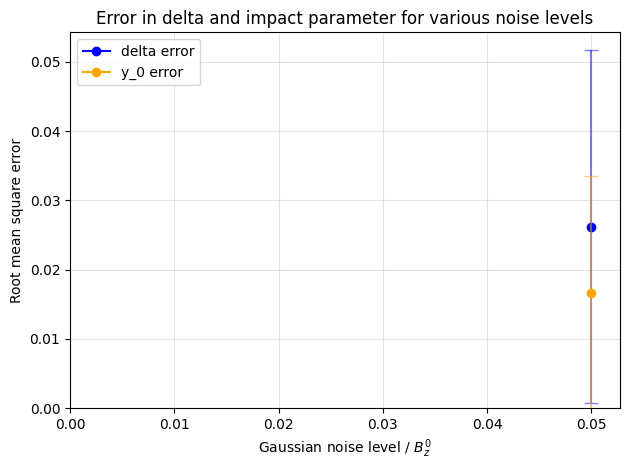

In [ ]:
fig, ax = plt.subplots(tight_layout=True)

ax.plot(noise_levels, stats["rms_delta_error"], "-o", label="delta error", color="b")
ax.errorbar(noise_levels, stats["rms_delta_error"], yerr=stats["std_delta_error"], color="b", capsize=5, alpha=0.5)

ax.plot(noise_levels, stats["rms_y_0_error"], "-o", label="y_0 error", color="orange")
ax.errorbar(noise_levels, stats["rms_y_0_error"], yerr=stats["std_y_0_error"], color="orange", capsize=5, alpha=0.5)

ax.grid(alpha=0.35)
ax.set_xlabel("Gaussian noise level / $B_z^0$")
ax.set_ylabel("Root mean square error")
ax.set_title("Error in delta and impact parameter for various noise levels")
ax.set_xlim(0)
ax.set_ylim(0)
ax.legend()

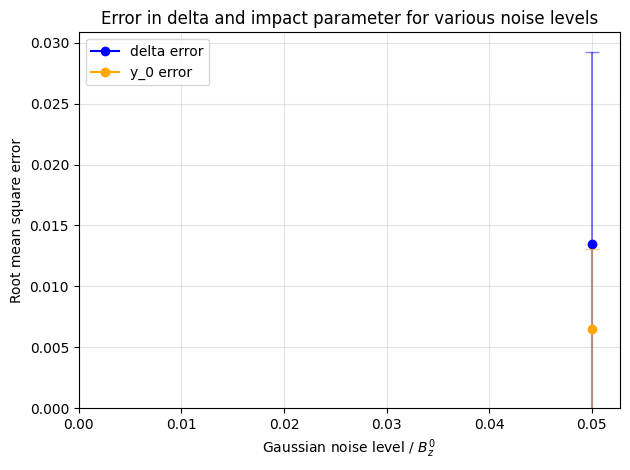

In [ ]:
fig, ax = plt.subplots(tight_layout=True)

ax.plot(noise_levels, stats["mean_absolute_delta_error"], "-o", label="delta error", color="b")
ax.errorbar(noise_levels, stats["mean_absolute_delta_error"], yerr=stats["std_delta_error"], color="b", capsize=5, alpha=0.5)

ax.plot(noise_levels, stats["mean_absolute_y_0_error"], "-o", label="y_0 error", color="orange")
ax.errorbar(noise_levels, stats["mean_absolute_y_0_error"], yerr=stats["std_y_0_error"], color="orange", capsize=5, alpha=0.5)

ax.grid(alpha=0.35)
ax.set_xlabel("Gaussian noise level / $B_z^0$")
ax.set_ylabel("Root mean square error")
ax.set_title("Error in delta and impact parameter for various noise levels")
ax.set_xlim(0)
ax.set_ylim(0)
ax.legend()

### 2.3 Pivot the tables

The raw results consist of a dataframe for each noise level. The row of each dataframe represents one fitting, with their corresponding $\delta$ and $y_0$ values. We pivot this table to obtain a new table where the columns indicate $\delta$ and the rows $y_0$.

In [ ]:
pivot_dfs: list[pd.DataFrame] = []
for noise_level, df in zip(noise_levels, dfs):
    pivot_df = df.pivot(index="y_0", columns="delta", values="combined_difference_sat_log10")
    pivot_dfs.append(pivot_df)

ValueError: Index contains duplicate entries, cannot reshape

In [ ]:
cmap: LinearSegmentedColormap = LinearSegmentedColormap.from_list("rg",["g", "w", "r"], N=256)

num_experiments: int = len(noise_levels)
n_cols: int = 3
n_rows: int = num_experiments // n_cols

MIN_GLOBAL: float = 1e9
MAX_GLOBAL: float = -1e9

# Take min and max of all pivot dataframes to get the global extreme values.
for noise_level, matrix in zip(noise_levels, pivot_dfs):  
    matrix_min = np.min(matrix)
    matrix_max = np.max(matrix)

    MIN_GLOBAL = min(MIN_GLOBAL, matrix_min)
    MAX_GLOBAL = max(MAX_GLOBAL, matrix_max)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(12, 12), tight_layout=True)

for ax_idx, (noise_level, matrix) in enumerate(zip(noise_levels, pivot_dfs)):
    y_0_range = matrix.index.to_list()
    delta_range = matrix.columns.to_list()
    Y_0, DELTA = np.meshgrid(delta_range, y_0_range)
    
    matrix_values = matrix.to_numpy()

    row_idx = ax_idx // n_cols
    col_idx = ax_idx % n_cols
    this_axis = ax[row_idx][col_idx]

    c = this_axis.pcolormesh(DELTA, Y_0, matrix_values, cmap=cmap, vmin=MIN_GLOBAL, vmax=MAX_GLOBAL) 
    this_axis.set_title(fr"Noise level $\epsilon$ = {noise_level:.3f}")
    this_axis.set_xlabel("$y_0$")
    this_axis.set_ylabel(r"$\delta$")
    fig.colorbar(c, ax=this_axis)

plt.suptitle("Combined error (log10)")
plt.show()

ValueError: Number of rows must be a positive integer, not 0

<Figure size 1200x1200 with 0 Axes>

In [ ]:
df = dfs[0]

fig, ax = plt.subplots(tight_layout=True)

for idx in range(len(df)):
    origin = [df.loc["delta", idx], df.loc["y_0", idx]]
    end  = [df.loc["delta_opt", idx], df.loc["y_0_opt", idx]]
    dx = end[0] - origin[0]
    dy = end[1] - origin[1]
    
    plt.arrow(origin[0], origin[1], dx, dy, head_width=0.2, head_length=0.3, fc='blue', ec='blue')


ax.grid(alpha=0.35)
ax.set_title(fr"Noise level $\epsilon$ = {noise_level:.3f}")
ax.set_xlabel("$y_0$")
ax.set_ylabel(r"$\delta$")


NameError: name 'dfs' is not defined

/var/folders/q2/zrh3sz712dbc665prw9v99q80000gn/T/ipykernel_25605/1891154716.py:25: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df.pivot_table(index=pd.cut(df['b'], bins=20),
/var/folders/q2/zrh3sz712dbc665prw9v99q80000gn/T/ipykernel_25605/1891154716.py:25: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = df.pivot_table(index=pd.cut(df['b'], bins=20),


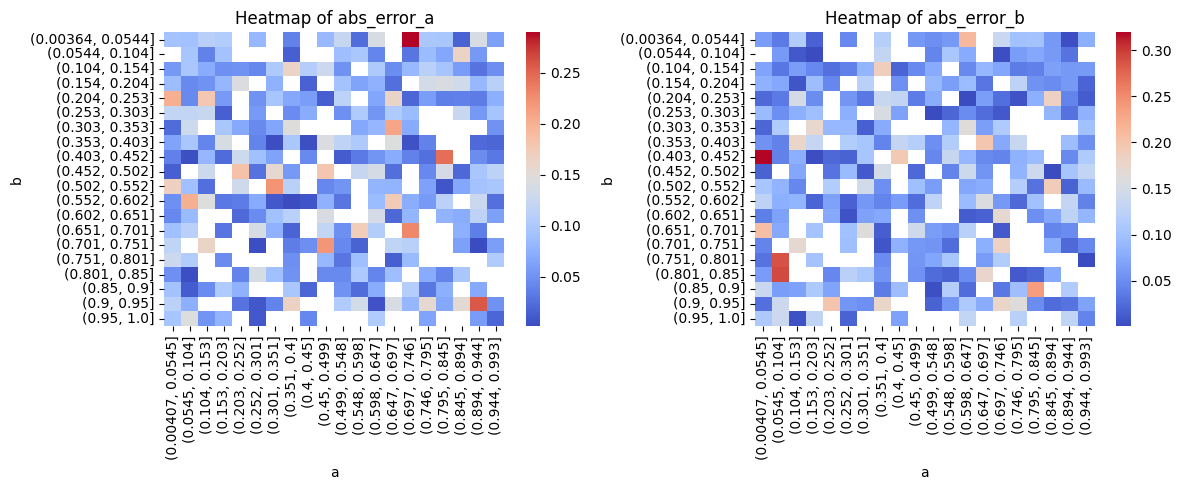

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data (replace with your actual data)
np.random.seed(42)
num_samples = 500
a = np.random.rand(num_samples)
b = np.random.rand(num_samples)
a_pred = a + np.random.normal(0, 0.1, num_samples)  # Simulating prediction errors
b_pred = b + np.random.normal(0, 0.1, num_samples)

# Compute absolute errors
abs_error_a = np.abs(a_pred - a)
abs_error_b = np.abs(b_pred - b)

# Create a DataFrame
df = pd.DataFrame({'a': a, 'b': b, 'abs_error_a': abs_error_a, 'abs_error_b': abs_error_b})

# Plot heatmaps using binning
plt.figure(figsize=(12, 5))
for i, col in enumerate(['abs_error_a', 'abs_error_b']):
    plt.subplot(1, 2, i + 1)
    pivot_table = df.pivot_table(index=pd.cut(df['b'], bins=20), 
                                 columns=pd.cut(df['a'], bins=20), 
                                 values=col, aggfunc='mean')
    sns.heatmap(pivot_table, cmap='coolwarm', cbar=True)
    plt.title(f'Heatmap of {col}')

plt.tight_layout()
plt.show()


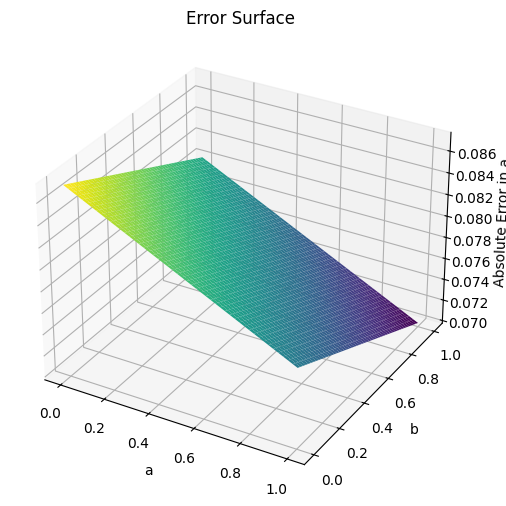

In [25]:
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D

# Fit a simple linear regression for error_a
X = np.column_stack((a, b))
y = abs_error_a
model = LinearRegression().fit(X, y)

# Predict over a grid
a_grid, b_grid = np.meshgrid(np.linspace(0, 1, 50), np.linspace(0, 1, 50))
y_pred = model.predict(np.column_stack((a_grid.ravel(), b_grid.ravel()))).reshape(50, 50)

# Plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(a_grid, b_grid, y_pred, cmap='viridis')
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('Absolute Error in a')
plt.title('Error Surface')
plt.show()


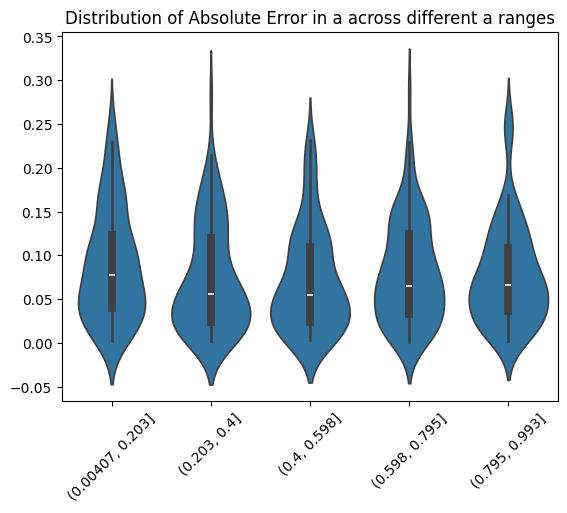

In [26]:
sns.violinplot(x=pd.cut(a, bins=5), y=abs_error_a)
plt.xticks(rotation=45)
plt.title("Distribution of Absolute Error in a across different a ranges")
plt.show()


In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Simulated data: 6D space
np.random.seed(42)
num_samples = 10000
df = pd.DataFrame({
    'a': np.random.rand(num_samples),
    'b': np.random.rand(num_samples),
    'c': np.random.rand(num_samples),
    'd': np.random.rand(num_samples),
    'e': np.random.rand(num_samples),
    'f': np.random.rand(num_samples),
    'a_pred': np.random.rand(num_samples),
    'b_pred': np.random.rand(num_samples),
})

# Compute absolute errors
df['abs_error_a'] = np.abs(df['a_pred'] - df['a'])
df['abs_error_b'] = np.abs(df['b_pred'] - df['b'])

# Slice space (fixing c, d, e, f at their median values)
df_slice = df[
    (df['c'].between(0.45, 0.55)) & 
    (df['d'].between(0.45, 0.55)) &
    (df['e'].between(0.45, 0.55)) &
    (df['f'].between(0.45, 0.55))
]

# Create a heatmap of abs_error_a in (a, b) space
heatmap_data = df_slice.pivot_table(index=pd.cut(df_slice['b'], bins=20), 
                                    columns=pd.cut(df_slice['a'], bins=20), 
                                    values='abs_error_a', aggfunc='mean')

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, cmap='coolwarm', cbar=True)
plt.title("Absolute Error in a across (a, b) subspace")
plt.xlabel("a")
plt.ylabel("b")
plt.show()


ValueError: Cannot cut empty array

In [27]:
from pandas.plotting import parallel_coordinates

df_sample = df.sample(500)  # Reduce number of points for visualization
df_sample['error_a'] = np.abs(df_sample['a_pred'] - df_sample['a'])

plt.figure(figsize=(10, 6))
parallel_coordinates(df_sample[['a', 'b', 'c', 'd', 'e', 'f', 'error_a']], class_column='error_a', colormap='coolwarm')
plt.title("Parallel Coordinates Plot")
plt.show()


KeyError: 'a_pred'